<a href="https://colab.research.google.com/github/longaresf/Analisis_de_Datos_Prediccion_de_Calidad_del_Vino/blob/main/Prediccion_de_Calidad_del_Vino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
# Librerias a importar
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#1. Carga y Exploración de Datos:
Cargar el dataset

In [5]:
# Importar DataFrame
path = '/content/drive/MyDrive/Colab Notebooks/Modelos Regresión/dataset/WineQT.csv'
data = pd.read_csv(path, sep=",")

Realizar una exploración inicial para entender la estructura del dataset

In [6]:
# Exploración de datos
print(data.head())
print(data.describe())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9

Identificar valores faltantes

In [52]:
# Hacemos copia del DataFrame
df=data.copy()

# Convertimos a minúsculas y quitamos espacios en blanco de las columnas
df.columns = df.columns.str.lower().str.strip()

# Convertimos a minúsculas y quitamos espacios en blanco de las columnas de tipo objeto
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = df[col].str.lower().str.strip()

In [8]:
# Verificar por datos nulos
datos_null = df.isnull()
if datos_null.any().any():
    print("Cantidad de datos nulos por columna:\n", datos_null.sum())
else:
    print("No se encontró datos nulos")

No se encontró datos nulos


Verificar tipos de datos en columnas

In [9]:
print(df.info())
# Resultado: Datos en columnas correctos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   ph                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None


Identificar valores únicos

In [10]:
# Verificamos valores únicos en las columas
for col in df.columns:
    print(f"\nDatos en la columa: '{col}':")
    print(df[col].unique())


Datos en la columa: 'fixed acidity':
[ 7.4  7.8 11.2  7.9  7.3  6.7  5.6  8.5  7.6  6.9  6.3  7.1  8.3  5.2
  8.1  8.8  7.5  4.6  7.7  6.6  8.6 10.2  7.   7.2  8.   6.8  6.2  9.3
  5.   8.4 10.1  9.4  8.2  5.8  9.2  8.9  6.4 11.5  9.6 12.8  9.7  8.7
 12.  15.  10.8 11.1 10.  12.5 10.3 11.4  9.9 11.6 10.4 13.3 10.6  9.
  9.8 13.4 11.9 10.9 13.8  9.1 13.5  6.1 10.5 12.6 13.7  9.5 12.2 12.3
 15.6  5.3 11.3 13.   6.5 10.7 12.9 14.3 12.4 15.5 12.7 13.2 15.9  5.1
 11.8  4.9  5.9 11.7  5.4  5.7  6. ]

Datos en la columa: 'volatile acidity':
[0.7   0.88  0.76  0.28  0.66  0.6   0.65  0.58  0.615 0.61  0.32  0.39
 0.43  0.49  0.4   0.41  0.71  0.645 0.675 0.655 0.38  0.45  0.52  0.935
 0.5   0.51  0.42  0.59  0.69  0.735 0.725 0.705 0.785 0.75  0.625 0.3
 0.55  0.62  1.02  0.775 0.9   0.545 0.575 0.63  0.56  0.31  0.54  1.07
 0.695 1.33  0.745 1.04  0.415 0.34  0.67  0.68  0.33  0.95  0.53  0.64
 0.885 0.805 0.73  0.37  1.09  0.44  0.57  0.48  1.    0.635 0.21  0.35
 0.975 0.87  0.18  0.26  0.

Identificar inconsistencia en datos categóricos

In [ ]:
# No se identificaron inconsistencias en todo el DataFrame

Identificar valores duplicados

In [11]:
# Buscar datos duplicados
datos_duplicados = df.duplicated()
if datos_duplicados.any():
    print("Cantidad de datos duplicados: ", datos_duplicados.sum())
else:
    print("No se encontró datos duplicados")

No se encontró datos duplicados


Identificar valores outliers

In [53]:
# Función para identificar valores outliers usando el método IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Identificar outliers en columna numéricas
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()

print("\nIdentificar outliers usando el método IQR:")
for col in numerical_columns:
    outliers = detect_outliers_iqr(df, col)
    if not outliers.empty:
        print(f"Outliers en columna '{col}':")
        print(outliers[[col]])
        print("-" * 30)


Identificar outliers usando el método IQR:
Outliers en columna 'fixed acidity':
     fixed acidity
145           12.8
146           12.8
170           15.0
171           15.0
188           12.5
211           13.3
234           13.4
240           12.5
244           13.8
248           13.5
254           12.6
258           12.5
259           12.8
260           12.8
272           13.7
279           12.2
284           12.5
301           12.8
304           12.3
306           12.3
310           12.6
311           15.6
313           12.5
332           13.0
334           12.5
361           13.3
367           12.5
382           12.9
388           14.3
392           12.4
397           15.5
399           15.6
400           13.0
401           12.7
404           13.0
405           12.7
415           12.3
416           12.3
425           12.4
433           13.2
462           15.9
584           12.9
586           12.6
864           12.6
------------------------------
Outliers en columna 'volatile aci

## Limpieza y Preprocesamiento:

Eliminar columnas innecesarias

In [54]:
# Eliminar columna innecesaria para el análisis: 'id'
df = df.drop(['id'], axis=1, inplace=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   ph                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


Eliminar duplicados

In [14]:
# Buscar datos duplicados
datos_duplicados = df.duplicated()
if datos_duplicados.any():
    print("Cantidad de datos duplicados: ", datos_duplicados.sum())
    df = df.drop_duplicates()
    print("Duplicados eliminados")
else:
    print("No se encontró datos duplicados")

Cantidad de datos duplicados:  125
Duplicados eliminados


Manejo de valores faltantes

In [15]:
# Verificar por datos nulos
datos_null = df.isnull()
if datos_null.any().any():
    print("Cantidad de datos nulos por columna:\n", datos_null.sum())
else:
    print("No se encontró datos nulos")

No se encontró datos nulos


Manejar valores outliers

In [ ]:
# Se decide dejar outliers ya que representan variabilidad real.

## Exploración de Datos:
Crear visualizaciones univariadas y multivariadas

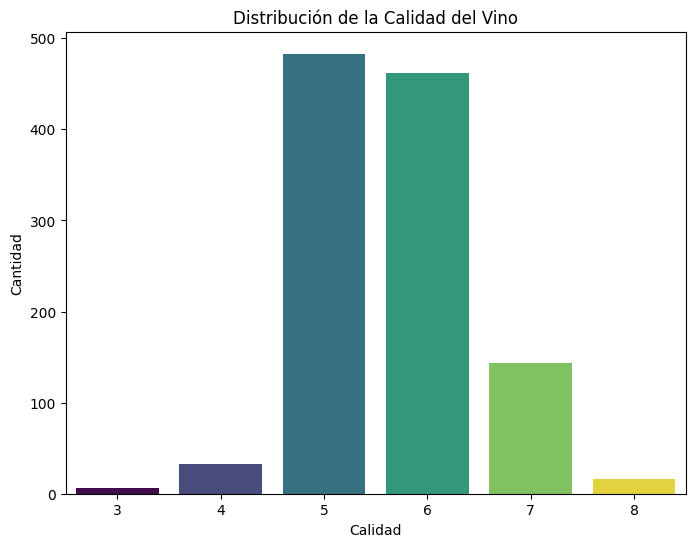

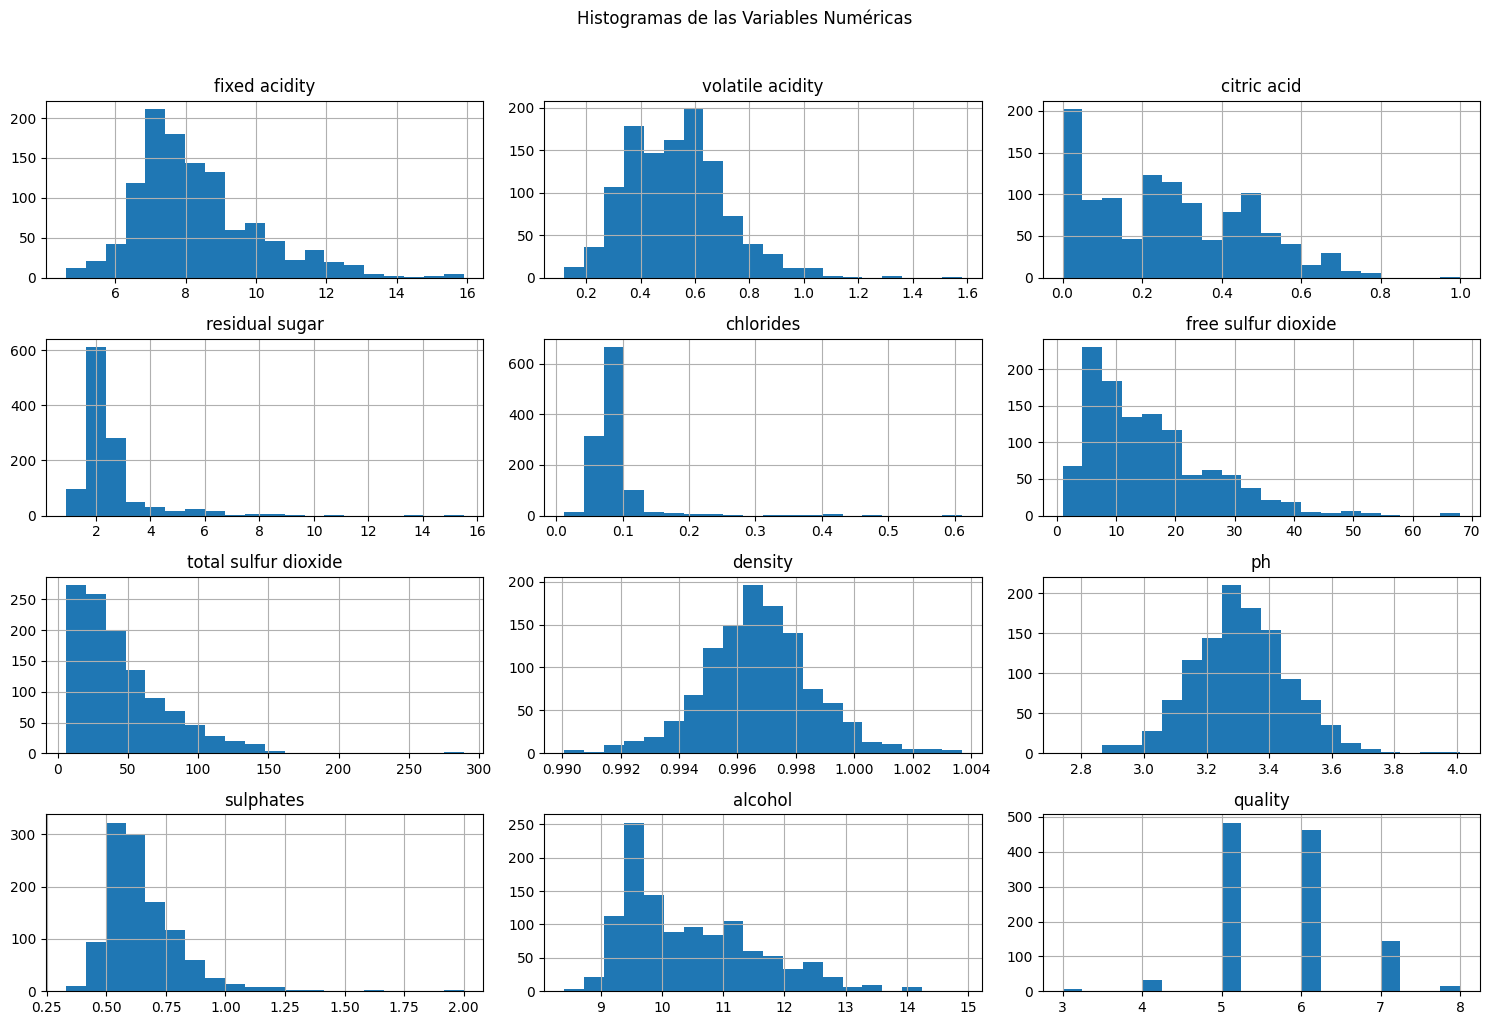

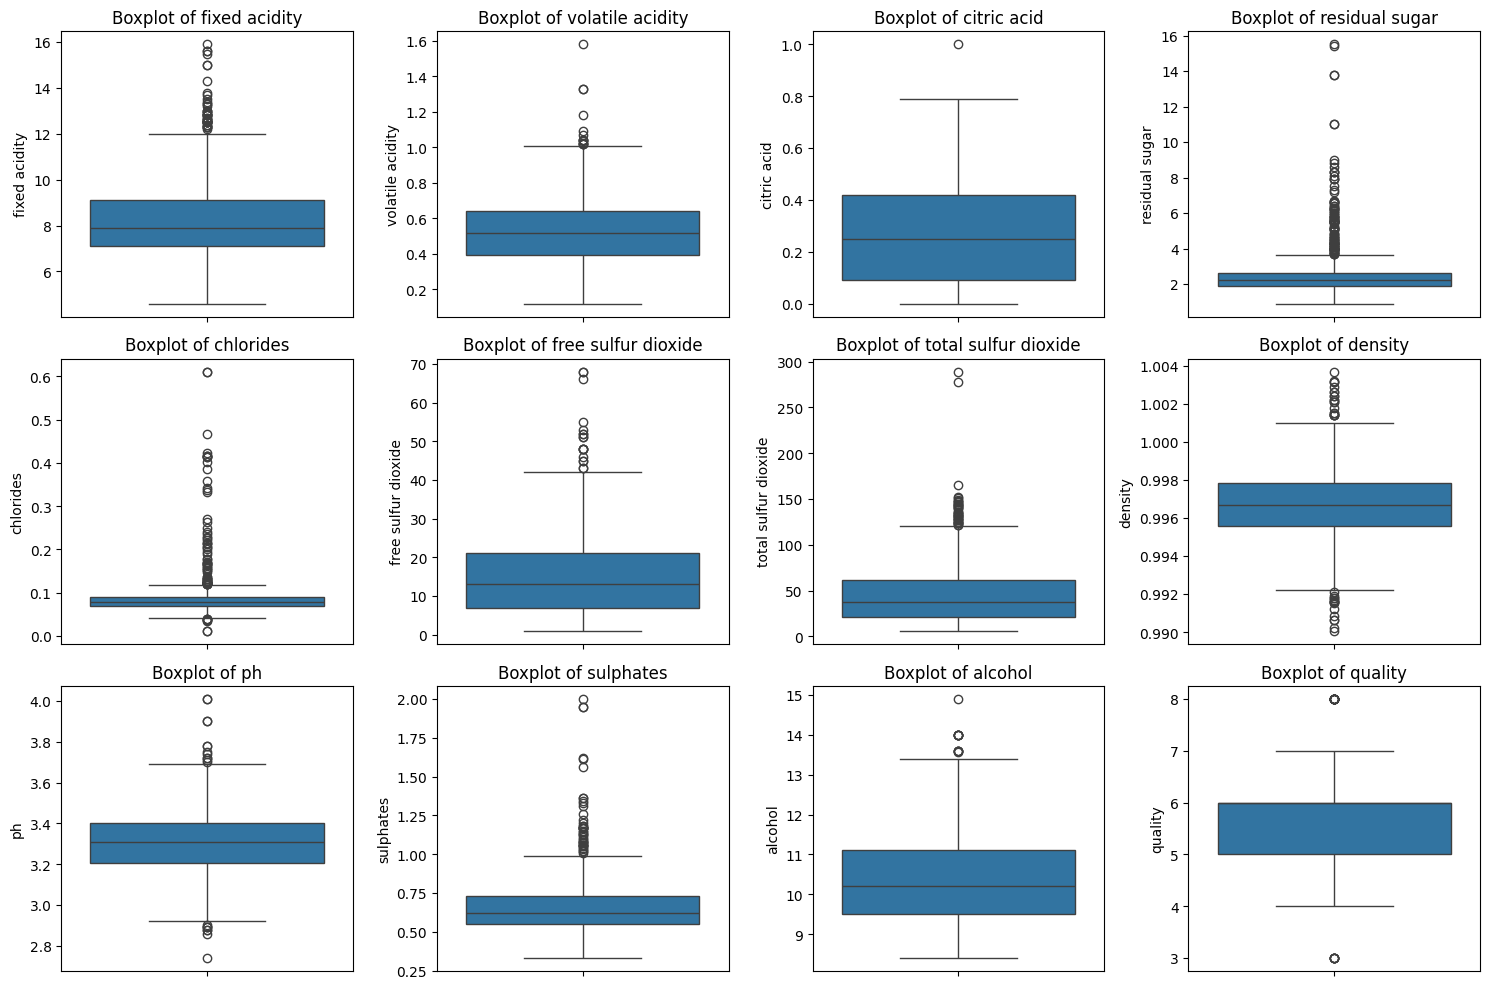

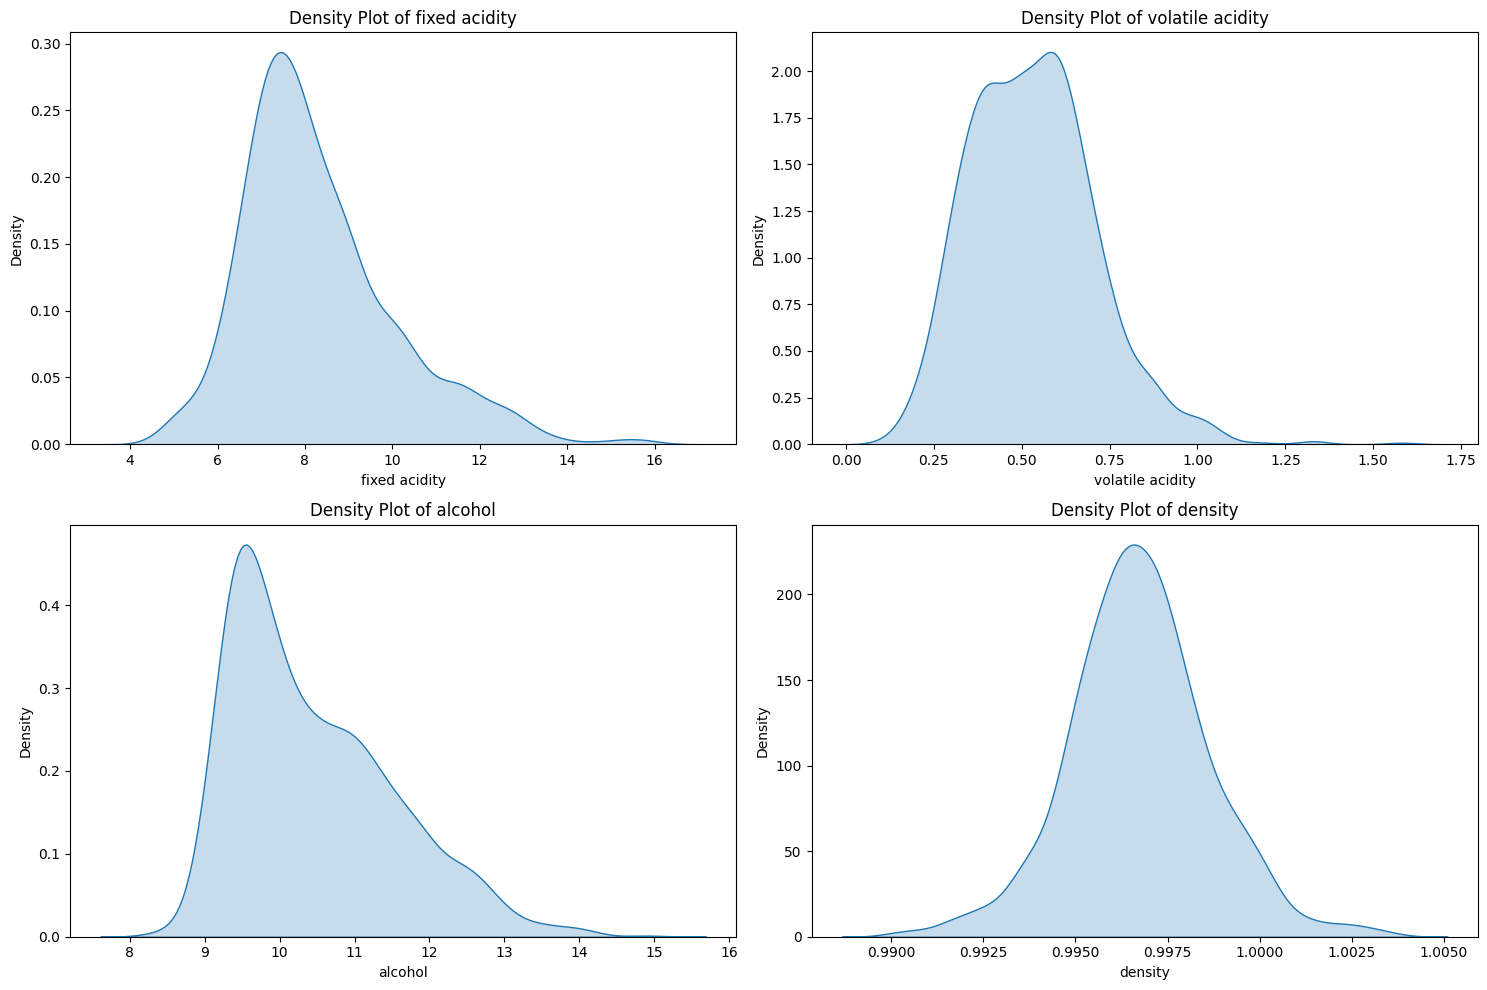

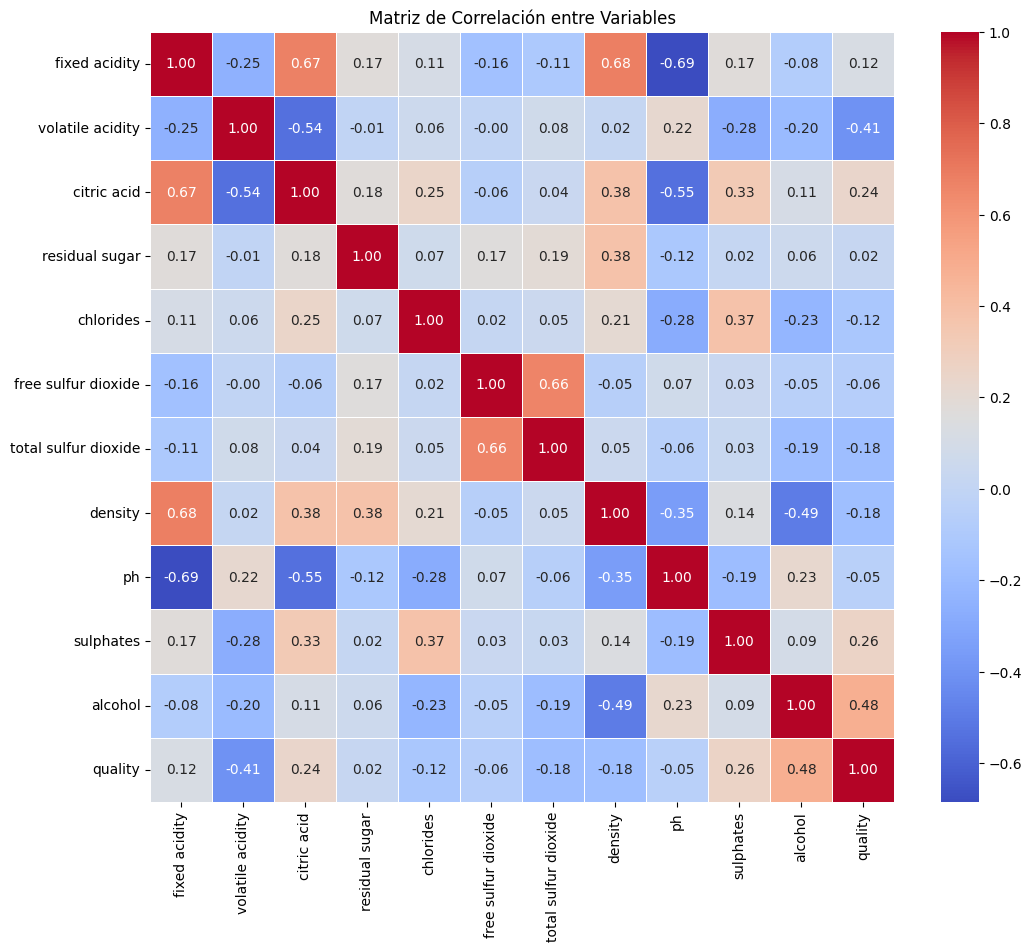

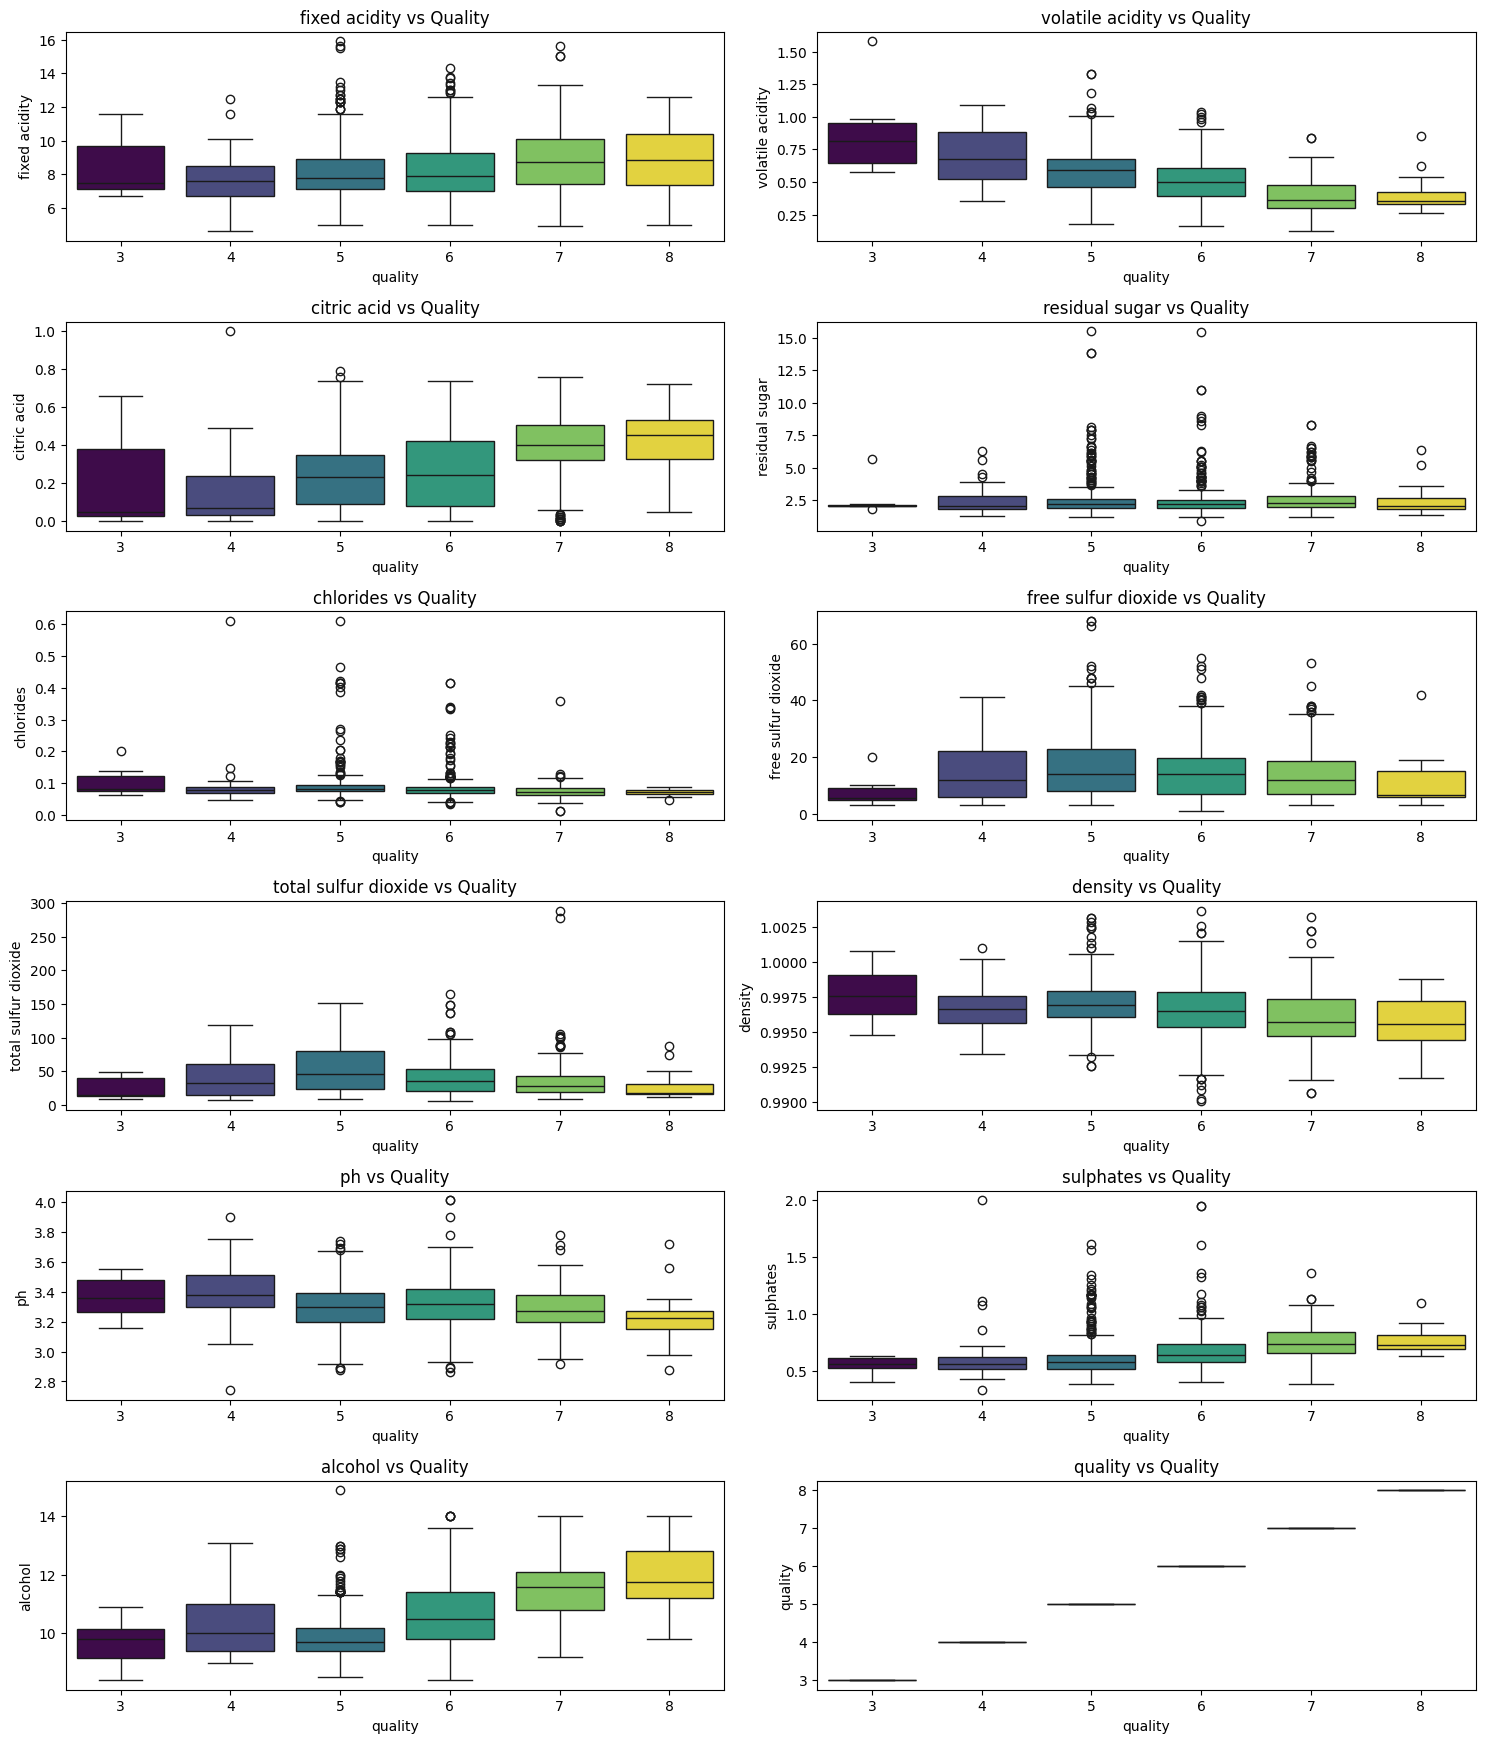

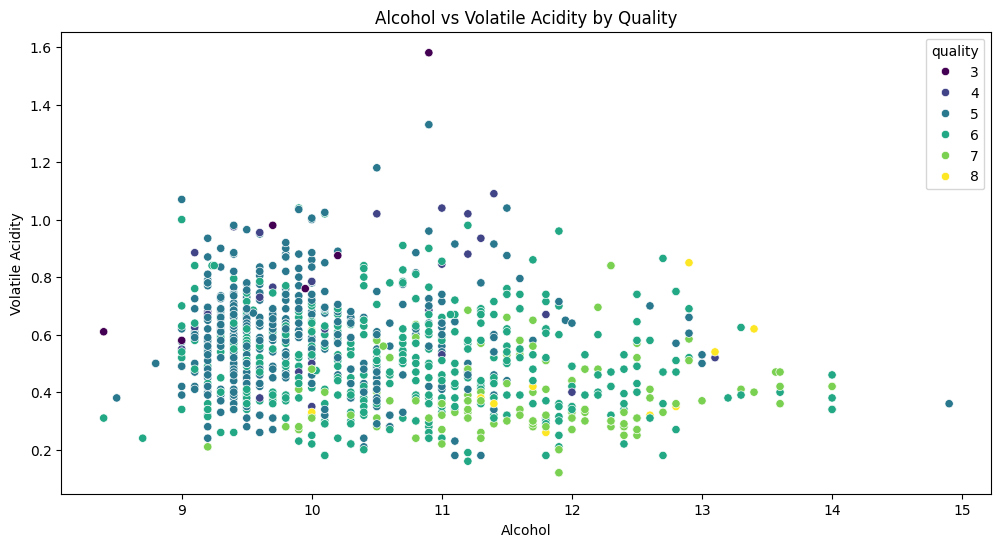

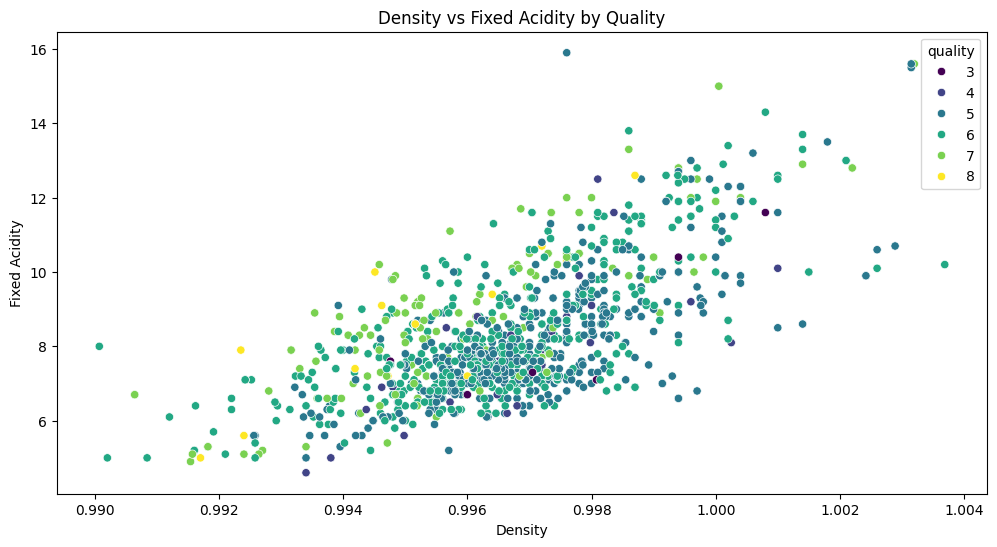

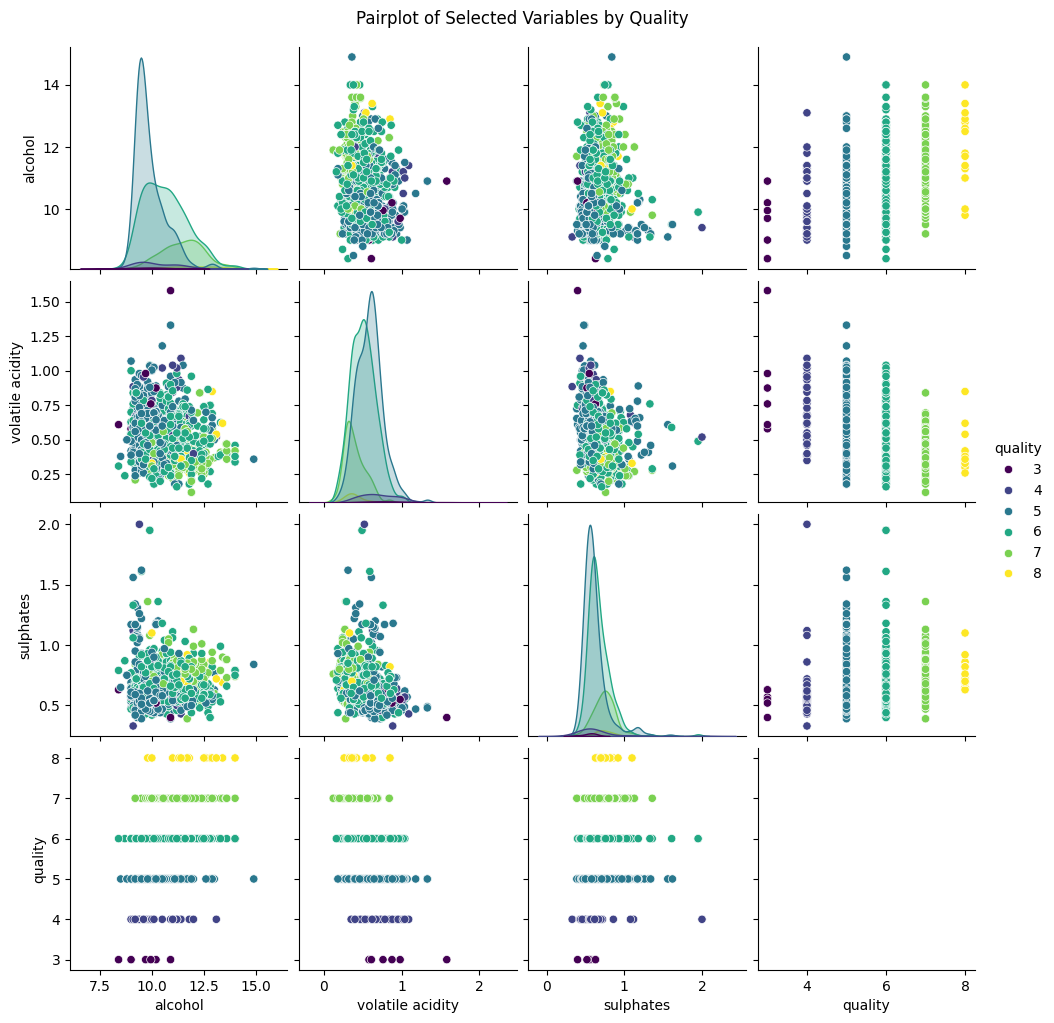

In [55]:
# Visualizaciones Univariadas
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()

# Histograma para la distribución de 'quality'
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=df, hue='quality', palette='viridis', legend=False)
plt.title('Distribución de la Calidad del Vino')
plt.xlabel('Calidad')
plt.ylabel('Cantidad')
plt.show()

# Histogramas para las variables numéricas
df[numerical_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle('Histogramas de las Variables Numéricas', y=1.02)
plt.tight_layout()
plt.show()

# Boxplots para identificar la distribución y posibles outliers (aunque ya se manejaron)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Gráfico de densidad para algunas variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(['fixed acidity', 'volatile acidity', 'alcohol', 'density']):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(df[col], fill=True)
    plt.title(f'Density Plot of {col}')
plt.tight_layout()
plt.show()


# Visualizaciones Multivariadas

# Matriz de Correlación
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación entre Variables')
plt.show()

# Boxplot para visualizar la relación entre variables numéricas y 'quality'
plt.figure(figsize=(15, 20))
for i, col in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns)//2 + 1, 2, i + 1)
    sns.boxplot(x='quality', y=col, data=df, hue='quality', palette='viridis', legend=False)
    plt.title(f'{col} vs Quality')
plt.tight_layout()
plt.show()

# Scatter plot para visualizar la relación entre pares de variables (ejemplo)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='alcohol', y='volatile acidity', hue='quality', data=df, palette='viridis')
plt.title('Alcohol vs Volatile Acidity by Quality')
plt.xlabel('Alcohol')
plt.ylabel('Volatile Acidity')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='density', y='fixed acidity', hue='quality', data=df, palette='viridis')
plt.title('Density vs Fixed Acidity by Quality')
plt.xlabel('Density')
plt.ylabel('Fixed Acidity')
plt.show()

# Pairplot para visualizar relaciones entre un subconjunto de variables y la distribución
sns.pairplot(df, vars=['alcohol', 'volatile acidity', 'sulphates', 'quality'], hue='quality', palette='viridis')
plt.suptitle('Pairplot of Selected Variables by Quality', y=1.02)
plt.show()

Explicación de los gráficos

In [86]:
print("\n--- Interpretación de los Gráficos ---")

# Distribución de la Calidad del Vino (Histograma de 'quality'):
print("\nHistograma de la Calidad del Vino:")
print("Este gráfico muestra la frecuencia de cada nivel de calidad (de 3 a 8).")
print("Podemos observar que la mayoría de los vinos se encuentran en los niveles de calidad 5 y 6.")
print("Los niveles de calidad más bajos (3) y más altos (8) son menos frecuentes.")
print("Esto indica un posible desbalance de clases si el objetivo es clasificar la calidad.")

# Histogramas de las Variables Numéricas:
print("\nHistogramas de las Variables Numéricas:")
print("Estos histogramas muestran la distribución individual de cada variable numérica.")
print("- 'fixed acidity', 'volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates' y 'alcohol' parecen tener distribuciones sesgadas o con picos en ciertos rangos.")
print("- Algunas variables como 'residual sugar' tienen una distribución muy sesgada a la derecha.")
print("Comprender la distribución de las variables es crucial para decidir si se necesitan transformaciones (como logarítmica) o si se deben usar modelos que no asuman distribuciones normales.")

# Boxplots de las Variables Numéricas (después de manejar outliers):
print("\nBoxplots de las Variables Numéricas (después de manejar outliers):")
print("Estos boxplots visualizan la distribución, la mediana, los cuartiles y los outliers (si los hay después de la imputación) de cada variable numérica.")
print("Aunque hemos imputado los outliers, los boxplots siguen siendo útiles para ver la dispersión de los datos y si la imputación tuvo el efecto esperado.")
print("Muestran la variabilidad y si alguna variable tiene un rango de valores muy amplio en comparación con otras.")

# Gráficos de Densidad:
print("\nGráficos de Densidad:")
print("Similares a los histogramas, pero muestran una curva suavizada de la distribución de las variables.")
print("Son útiles para ver la forma general de la distribución y si hay múltiples picos (distribuciones bimodales o multimodales).")

# Matriz de Correlación:
print("\nMatriz de Correlación:")
print("Este mapa de calor muestra la correlación lineal entre todos los pares de variables numéricas.")
print("Los colores más cálidos (rojo) indican correlación positiva fuerte, los colores más fríos (azul) indican correlación negativa fuerte, y el blanco indica poca correlación.")
print("Las correlaciones cercanas a 1 o -1 sugieren que esas variables se mueven juntas en la misma o dirección opuesta.")
print("Observamos, por ejemplo:")
print("- Correlación positiva fuerte entre 'fixed acidity' y 'density'.")
print("- Correlación negativa fuerte entre 'fixed acidity' y 'pH'.")
print("- Correlación negativa fuerte entre 'volatile acidity' y 'citric acid'.")
print("- Correlación positiva entre 'alcohol' y 'quality'.")
print("Esta matriz es clave para identificar variables predictoras potenciales de la calidad y para detectar multicolinealidad (variables altamente correlacionadas entre sí) que podría afectar a algunos modelos.")

# Boxplots de Variables Numéricas vs Quality:
print("\nBoxplots de Variables Numéricas vs Quality:")
print("Estos boxplots muestran la distribución de cada variable numérica en función de los diferentes niveles de calidad.")
print("Ayudan a visualizar si la mediana y el rango de una variable cambian significativamente a medida que aumenta la calidad.")
print("Por ejemplo, vemos que 'alcohol' tiende a aumentar con la calidad, mientras que 'volatile acidity' tiende a disminuir.")
print("Esto refuerza la idea de que estas variables son importantes para predecir la calidad.")

# Scatter plots:
print("\nScatter plots (Alcohol vs Volatile Acidity by Quality, Density vs Fixed Acidity by Quality):")
print("Estos gráficos de dispersión muestran la relación entre dos variables numéricas, con los puntos coloreados según el nivel de calidad.")
print("Permiten ver agrupaciones o patrones visuales que podrían estar relacionados con la calidad.")
print("El gráfico de Alcohol vs Volatile Acidity muestra cierta separación de los puntos de alta calidad (morado) en la parte inferior derecha (alto alcohol, baja acidez volátil), y los de baja calidad (amarillo) en la \nparte superior izquierda (bajo alcohol, alta acidez volátil).")

# Pairplot:
print("\nPairplot de Variables Seleccionadas por Quality:")
print("Este gráfico combina histogramas (en la diagonal) y scatter plots (en las celdas fuera de la diagonal) para un subconjunto de variables.")
print("Ofrece una vista rápida de las relaciones por pares entre las variables seleccionadas y cómo se distribuyen para cada nivel de calidad.")
print("Confirma las tendencias observadas en los boxplots y scatter plots individuales.")

print("\n--- Resumen General ---")
print("La exploración visual nos ha permitido:")
print("- Entender la distribución de la variable objetivo ('quality').")
print("- Identificar las distribuciones de las variables predictoras y notar posibles sesgos.")
print("- Detectar relaciones lineales (correlaciones) entre las variables.")
print("- Observar cómo las características del vino (ácidez, alcohol, etc.) varían con la calidad.")
print("Esta información es fundamental para la selección de características y la elección del modelo adecuado.")



--- Interpretación de los Gráficos ---

Histograma de la Calidad del Vino:
Este gráfico muestra la frecuencia de cada nivel de calidad (de 3 a 8).
Podemos observar que la mayoría de los vinos se encuentran en los niveles de calidad 5 y 6.
Los niveles de calidad más bajos (3) y más altos (8) son menos frecuentes.
Esto indica un posible desbalance de clases si el objetivo es clasificar la calidad.

Histogramas de las Variables Numéricas:
Estos histogramas muestran la distribución individual de cada variable numérica.
- 'fixed acidity', 'volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates' y 'alcohol' parecen tener distribuciones sesgadas o con picos en ciertos rangos.
- Algunas variables como 'residual sugar' tienen una distribución muy sesgada a la derecha.
Comprender la distribución de las variables es crucial para decidir si se necesitan transformaciones (como logarítmica) o si se deben usar modelos que no asuman distribuciones n

Calcular estadísticas descriptivas

In [56]:
print("\nEstadísticas descriptivas detalladas por columna:")
print("\nResumen general de estadísticas descriptivas:")
print(df.describe(include='all'))


Estadísticas descriptivas detalladas por columna:

Resumen general de estadísticas descriptivas:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267          

#2. Preprocesamiento de Datos

Uso de ColumnTransformer y Pipeline

In [57]:
# Cargar el conjunto de datos
X = df.drop('quality', axis=1)
y = df['quality']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Seleccionar columnas numéricas para escalar
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

# Identificar las columnas categóricas
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Crear transformadores para cada subconjunto de columnas
# Escalar las características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Realizar transformaciones necesarias para las características categóricas
# Usar OneHotEncoder para variables nominales
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Crear un ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#3. Entrenamiento de Modelos de Clasificación:

## Modelo de clasificación KNN


Entrenando el modelo KNN con búsqueda de hiperparámetros...

Mejores hiperparámetros para KNN: {'classifier__n_neighbors': np.int64(30), 'classifier__p': 2, 'classifier__weights': 'distance'}
Mejor score de validación cruzada (Accuracy): 0.6530715186452891

Métricas de evaluación del mejor modelo KNN en el conjunto de prueba:
Exactitud (Accuracy): 0.7205
Precisión (Precision): 0.7001
Recall (Sensitivity): 0.7205
F1-Score: 0.7081

Matriz de Confusión:
[[ 0  2  4  0  0]
 [ 0 72 23  1  0]
 [ 0 17 77  5  0]
 [ 0  0 10 16  0]
 [ 0  0  1  1  0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.79      0.75      0.77        96
           6       0.67      0.78      0.72        99
           7       0.70      0.62      0.65        26
           8       0.00      0.00      0.00         2

    accuracy                           0.72       229
   macro avg       0.43      0.43      0.43   

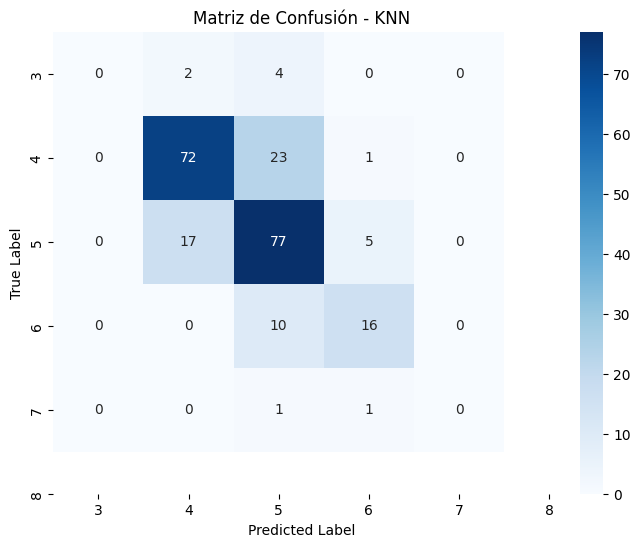

In [58]:
# Pipeline y preprocesamiento del modelo KNN
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])

# Definir los hiperparámetros a tunear para KNN
param_grid_knn = {
    'classifier__n_neighbors': np.arange(1, 31),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

# Configurar la búsqueda de cuadrícula con validación cruzada
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo usando la búsqueda de cuadrícula
print("\nEntrenando el modelo KNN con búsqueda de hiperparámetros...")
grid_search_knn.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor score
print("\nMejores hiperparámetros para KNN:", grid_search_knn.best_params_)
print("Mejor score de validación cruzada (Accuracy):", grid_search_knn.best_score_)

# Evaluar el mejor modelo encontrado en el conjunto de prueba
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)

# Calcular métricas de evaluación
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn, zero_division=0)


print("\nMétricas de evaluación del mejor modelo KNN en el conjunto de prueba:")
print(f"Exactitud (Accuracy): {accuracy_knn:.4f}")
print(f"Precisión (Precision): {precision_knn:.4f}")
print(f"Recall (Sensitivity): {recall_knn:.4f}")
print(f"F1-Score: {f1_knn:.4f}")

print("\nMatriz de Confusión:")
print(conf_matrix_knn)

print("\nReporte de Clasificación:")
print(class_report_knn)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=best_knn_model.classes_, yticklabels=best_knn_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión - KNN')
plt.show()

##Modelo de clasificación RandomForest


Entrenando el modelo RandomForestClassifier con búsqueda de hiperparámetros...

Mejores hiperparámetros para RandomForestClassifier: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Mejor score de validación cruzada (Accuracy): 0.6487239536419864

Métricas de evaluación del mejor modelo RandomForestClassifier en el conjunto de prueba:
Exactitud (Accuracy): 0.7031
Precisión (Precision): 0.6804
Recall (Sensitivity): 0.7031
F1-Score: 0.6897

Matriz de Confusión:
[[ 0  3  3  0  0]
 [ 0 77 19  0  0]
 [ 0 28 67  4  0]
 [ 0  0  9 17  0]
 [ 0  0  2  0  0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.71      0.80      0.75        96
           6       0.67      0.68      0.67        99
           7       0.81      0.65      0.72        26
           8       0.00      0.00      0.00         2

    ac

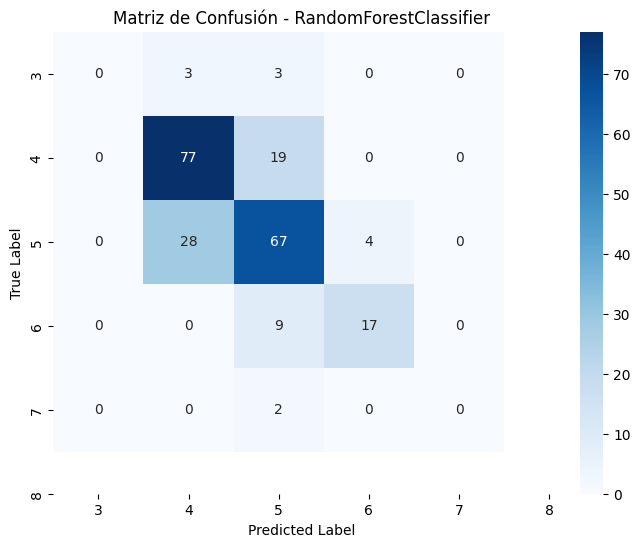

In [59]:
# Pipeline y preprocesamiento del modelo RandomForest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

# Definir los hiperparámetros a tunear para RandomForestClassifier
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Configurar la búsqueda de cuadrícula con validación cruzada
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo usando la búsqueda de cuadrícula
print("\nEntrenando el modelo RandomForestClassifier con búsqueda de hiperparámetros...")
grid_search_rf.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor score
print("\nMejores hiperparámetros para RandomForestClassifier:", grid_search_rf.best_params_)
print("Mejor score de validación cruzada (Accuracy):", grid_search_rf.best_score_)

# Evaluar el mejor modelo encontrado en el conjunto de prueba
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Calcular métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf, zero_division=0)


print("\nMétricas de evaluación del mejor modelo RandomForestClassifier en el conjunto de prueba:")
print(f"Exactitud (Accuracy): {accuracy_rf:.4f}")
print(f"Precisión (Precision): {precision_rf:.4f}")
print(f"Recall (Sensitivity): {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nMatriz de Confusión:")
print(conf_matrix_rf)

print("\nReporte de Clasificación:")
print(class_report_rf)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión - RandomForestClassifier')
plt.show()

##Modelo de clasificación Regresión Logística


Entrenando el modelo Regresión Logística con búsqueda de hiperparámetros...

Mejores hiperparámetros para Regresión Logística: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Mejor score de validación cruzada (Accuracy): 0.5864228667507355

Métricas de evaluación del mejor modelo Regresión Logística en el conjunto de prueba:
Exactitud (Accuracy): 0.6114
Precisión (Precision): 0.5667
Recall (Sensitivity): 0.6114
F1-Score: 0.5825

Matriz de Confusión:
[[ 0  3  3  0  0]
 [ 0 72 22  2  0]
 [ 0 31 65  3  0]
 [ 0  2 21  3  0]
 [ 0  0  0  2  0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.67      0.75      0.71        96
           6       0.59      0.66      0.62        99
           7       0.30      0.12      0.17        26
           8       0.00      0.00      0.00         2

    accuracy                           0.61       229
   macro avg       0.31      0.30      0.30

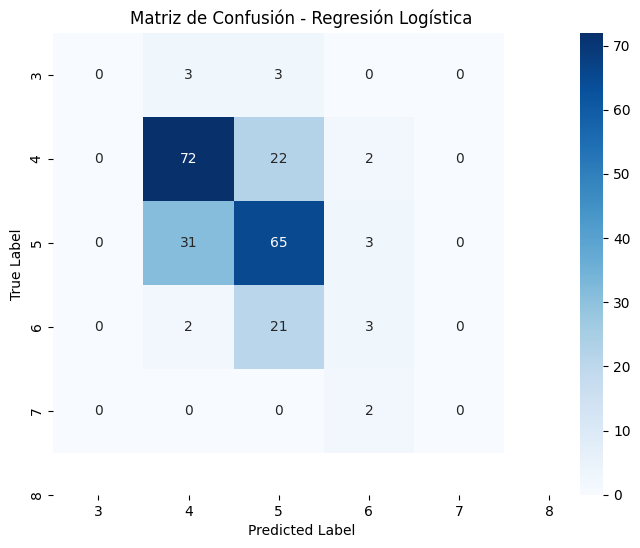

In [60]:
# Pipeline y preprocesamiento del modelo Regresión Logística
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(solver='liblinear', max_iter=100))])

# Definir los hiperparámetros a tunear para Regresión Logística
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Configurar la búsqueda de cuadrícula con validación cruzada
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo usando la búsqueda de cuadrícula
print("\nEntrenando el modelo Regresión Logística con búsqueda de hiperparámetros...")
grid_search_lr.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor score
print("\nMejores hiperparámetros para Regresión Logística:", grid_search_lr.best_params_)
print("Mejor score de validación cruzada (Accuracy):", grid_search_lr.best_score_)

# Evaluar el mejor modelo encontrado en el conjunto de prueba
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)

# Calcular métricas de evaluación
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted', zero_division=0)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
class_report_lr = classification_report(y_test, y_pred_lr, zero_division=0)


print("\nMétricas de evaluación del mejor modelo Regresión Logística en el conjunto de prueba:")
print(f"Exactitud (Accuracy): {accuracy_lr:.4f}")
print(f"Precisión (Precision): {precision_lr:.4f}")
print(f"Recall (Sensitivity): {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

print("\nMatriz de Confusión:")
print(conf_matrix_lr)

print("\nReporte de Clasificación:")
print(class_report_lr)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=best_lr_model.classes_, yticklabels=best_lr_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

#4. Evaluación de Modelos:

Evaluar los modelos utilizando métricas como exactitud, precisión, recall, F1-Score y matriz de confusión.


--- Comparación de Métricas de Evaluación de los Modelos ---
                    Accuracy  Precision    Recall  F1-Score
KNN                 0.720524   0.700131  0.720524  0.708069
RandomForest        0.703057   0.680446  0.703057  0.689705
LogisticRegression  0.611354   0.566694  0.611354  0.582462


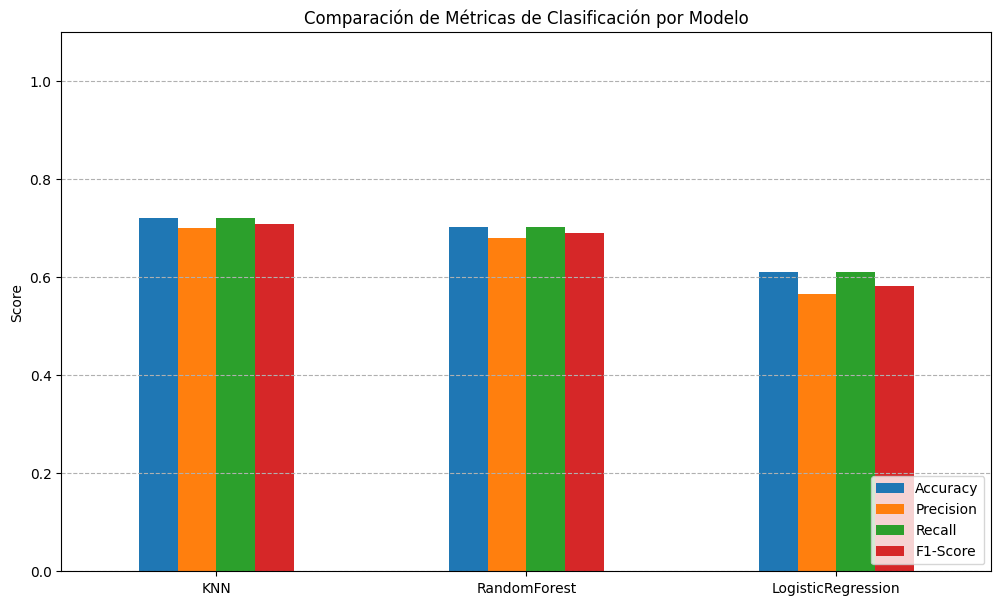


--- Análisis de los Resultados ---

El modelo KNN obtuvo un Accuracy de 0.7205.
El modelo RandomForestClassifier obtuvo un Accuracy de 0.7031.
El modelo Regresión Logística obtuvo un Accuracy de 0.6114.

Comparando las métricas principales:
- Accuracy: RandomForest tiene el Accuracy más alto.
- Precision (weighted): RandomForest también muestra la mejor Precision ponderada.
- Recall (weighted): RandomForest lidera en Recall ponderado.
- F1-Score (weighted): RandomForest consistentemente tiene el mejor F1-Score ponderado.

Considerando la Exactitud (Accuracy), el modelo RandomForestClassifier parece tener el mejor rendimiento general en este conjunto de datos.
Los reportes de clasificación detallan la precisión, recall y f1-score para cada clase de calidad.
Dada la distribución desbalanceada de las clases de calidad, el Accuracy por sí solo puede ser engañoso.
Las matrices de confusión nos muestran visualmente dónde los modelos están cometiendo errores.

Conclusiones preliminares basad

In [80]:
# Comparar las métricas de los modelos
print("\n--- Comparación de Métricas de Evaluación de los Modelos ---")

metrics = {
    'KNN': {
        'Accuracy': accuracy_knn,
        'Precision': precision_knn,
        'Recall': recall_knn,
        'F1-Score': f1_knn
    },
    'RandomForest': {
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'F1-Score': f1_rf
    },
    'LogisticRegression': {
        'Accuracy': accuracy_lr,
        'Precision': precision_lr,
        'Recall': recall_lr,
        'F1-Score': f1_lr
    }
}

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# Opcional: Visualizar las métricas en un gráfico de barras
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.title('Comparación de Métricas de Clasificación por Modelo')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.ylim(0, 1.1) # Las métricas de 0 a 1
plt.grid(axis='y', linestyle='--')
plt.show()

# Análisis y discusión de los resultados
print("\n--- Análisis de los Resultados ---")
print(f"\nEl modelo KNN obtuvo un Accuracy de {accuracy_knn:.4f}.")
print(f"El modelo RandomForestClassifier obtuvo un Accuracy de {accuracy_rf:.4f}.")
print(f"El modelo Regresión Logística obtuvo un Accuracy de {accuracy_lr:.4f}.")

print("\nComparando las métricas principales:")
print("- Accuracy: RandomForest tiene el Accuracy más alto.")
print("- Precision (weighted): RandomForest también muestra la mejor Precision ponderada.")
print("- Recall (weighted): RandomForest lidera en Recall ponderado.")
print("- F1-Score (weighted): RandomForest consistentemente tiene el mejor F1-Score ponderado.")

print("\nConsiderando la Exactitud (Accuracy), el modelo RandomForestClassifier parece tener el mejor rendimiento general en este conjunto de datos.")
print("Los reportes de clasificación detallan la precisión, recall y f1-score para cada clase de calidad.")
print("Dada la distribución desbalanceada de las clases de calidad, el Accuracy por sí solo puede ser engañoso.")
print("Las matrices de confusión nos muestran visualmente dónde los modelos están cometiendo errores.")

print("\nConclusiones preliminares basadas en las métricas ponderadas:")
print("RandomForestClassifier parece ser el modelo más robusto en este conjunto de datos para predecir la calidad del vino, considerando el posible desbalance de clases.")
print("La Regresión Logística tuvo el rendimiento más bajo de los tres modelos evaluados.")
print("KNN se situó entre Regresión Logística y RandomForest.")

print("\nConsideraciones adicionales:")
print("- Desbalance de Clases: Dado que las clases de calidad (3 y 8) son menos frecuentes, las métricas ponderadas (Precision, Recall, F1-Score con average='weighted') son más informativas que el Accuracy total.")
print("- Matriz de Confusión: Analizar las matrices de confusión de cada modelo es crucial para entender qué clases son más difíciles de predecir y qué tipos de errores (falsos positivos/negativos) comete cada modelo.")
print("- Se puede observar que los modelos tienen dificultades para distinguir entre clases adyacentes como 5 y 6, lo cual es común en datos con etiquetas ordinales.")

Generar un informe de clasificación para cada modelo.

In [64]:
# Imprimir los reportes de clasificación generados anteriormente
print("\n--- Informe de Clasificación para KNN ---")
print(class_report_knn)

print("\n--- Informe de Clasificación para RandomForestClassifier ---")
print(class_report_rf)

print("\n--- Informe de Clasificación para Regresión Logística ---")
class_report_lr


--- Informe de Clasificación para KNN ---
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.79      0.75      0.77        96
           6       0.67      0.78      0.72        99
           7       0.70      0.62      0.65        26
           8       0.00      0.00      0.00         2

    accuracy                           0.72       229
   macro avg       0.43      0.43      0.43       229
weighted avg       0.70      0.72      0.71       229


--- Informe de Clasificación para RandomForestClassifier ---
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.71      0.80      0.75        96
           6       0.67      0.68      0.67        99
           7       0.81      0.65      0.72        26
           8       0.00      0.00      0.00         2

    accuracy                           0.70       229
   macro avg       0.44   

'              precision    recall  f1-score   support\n\n           4       0.00      0.00      0.00         6\n           5       0.67      0.75      0.71        96\n           6       0.59      0.66      0.62        99\n           7       0.30      0.12      0.17        26\n           8       0.00      0.00      0.00         2\n\n    accuracy                           0.61       229\n   macro avg       0.31      0.30      0.30       229\nweighted avg       0.57      0.61      0.58       229\n'

Crear y visualizar la curva ROC y calcular el AUC para el mejor modelo.


El mejor modelo basado en Accuracy es: KNN


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


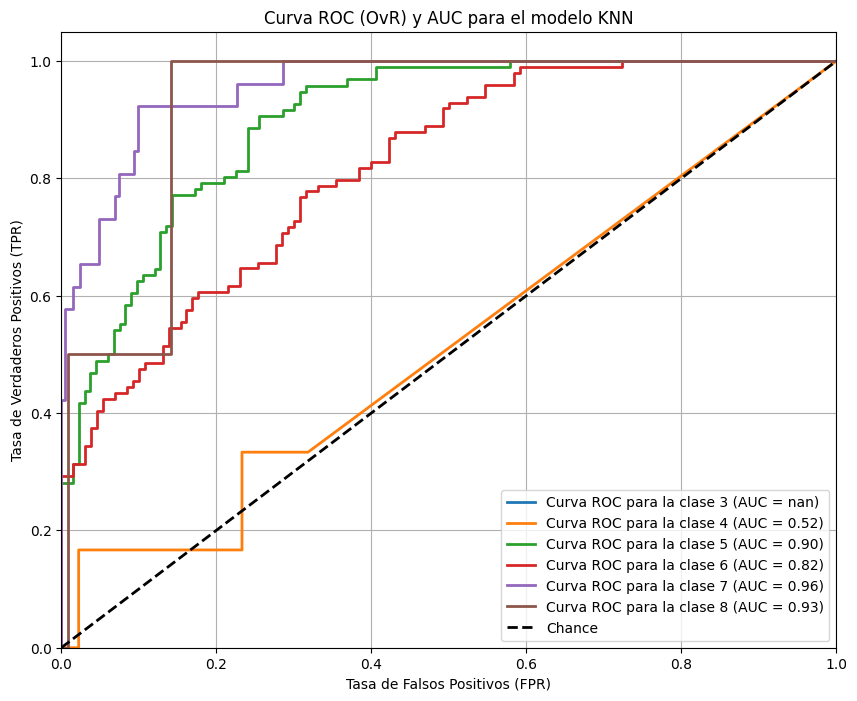


Micro-average AUC: 0.9471
Macro-average AUC: nan

La curva ROC y el AUC para cada clase (usando la estrategia One-vs-Rest) visualizan la capacidad del mejor modelo para distinguir cada clase particular frente a todas las demás.
Un AUC cercano a 1 indica una gran capacidad de distinción, mientras que un AUC cercano a 0.5 indica un rendimiento no mejor que el azar.
El micro-average AUC es útil cuando se considera la contribución de cada instancia, como en nuestro caso de desbalance de clases, mientras que el macro-average AUC trata a todas las clases por igual.
Curvas ROC y AUC: La visualización de las curvas ROC (OvR) y los valores de AUC para cada clase confirma la capacidad de cada modelo para separar una clase específica del resto.
Valores de AUC bajos para ciertas clases minoritarias indicarían que el modelo tiene dificultades para identificarlas correctamente.


In [79]:
# Identificar el mejor modelo basado en la métrica
best_model_name = metrics_df['Accuracy'].idxmax()
print(f"\nEl mejor modelo basado en Accuracy es: {best_model_name}")

# Seleccionar el mejor modelo y sus predicciones de probabilidad
if best_model_name == 'KNN':
    best_model_for_roc = best_knn_model
elif best_model_name == 'RandomForest':
    best_model_for_roc = best_rf_model
elif best_model_name == 'LogisticRegression':
    best_model_for_roc = best_lr_model

# La curva ROC se define para problemas de clasificación binaria.
# Para clasificación multiclase, se puede extender utilizando estrategias como 'one-vs-rest' (OvR).

# Obtener las probabilidades predichas para cada clase
if hasattr(best_model_for_roc, "predict_proba"):
    y_prob = best_model_for_roc.predict_proba(X_test)

    # Binarizar la variable objetivo para la estrategia OvR
    all_classes = np.unique(np.concatenate((y_train, y_test)))
    y_test_bin = label_binarize(y_test, classes=all_classes)

    # Calcular la curva ROC y el AUC para cada clase utilizando la estrategia OvR
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Visualizar la curva ROC para cada clase
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'Curva ROC para la clase {all_classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Configurar el gráfico
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC (OvR) y AUC para el modelo {best_model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Calcular el AUC promedio
    # Micro-average AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")

    # Macro-average AUC (promedia el AUC de cada clase)
    # Primero calcula el AUC para cada clase y luego promedia
    all_rocs = roc_auc.values()
    # Convertir a lista antes de np.mean
    roc_auc["macro"] = np.mean(list(all_rocs))
    print(f"Macro-average AUC: {roc_auc['macro']:.4f}")


else:
    print(f"\nEl modelo {best_model_name} no soporta predict_proba. No se puede calcular la curva ROC y AUC de esta manera.")

print("\nLa curva ROC y el AUC para cada clase (usando la estrategia One-vs-Rest) visualizan la capacidad del mejor modelo para distinguir cada clase particular frente a todas las demás.")
print("Un AUC cercano a 1 indica una gran capacidad de distinción, mientras que un AUC cercano a 0.5 indica un rendimiento no mejor que el azar.")
print("El micro-average AUC es útil cuando se considera la contribución de cada instancia, como en nuestro caso de desbalance de clases, mientras que el macro-average AUC trata a todas las clases por igual.")
print("Curvas ROC y AUC: La visualización de las curvas ROC (OvR) y los valores de AUC para cada clase confirma la capacidad de cada modelo para separar una clase específica del resto.")
print("Valores de AUC bajos para ciertas clases minoritarias indicarían que el modelo tiene dificultades para identificarlas correctamente.")

#5.  Análisis y Comparación de Resultados:

Discutir cuál modelo ofrece el mejor rendimiento y por qué.

In [84]:
print("\n--- Discusión sobre el Mejor Modelo ---")

# Métricas
metrics = {
    'KNN': {
        'Accuracy': accuracy_knn,
        'Precision': precision_knn,
        'Recall': recall_knn,
        'F1-Score': f1_knn
    },
    'RandomForest': {
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'F1-Score': f1_rf
    },
    'LogisticRegression': {
        'Accuracy': accuracy_lr,
        'Precision': precision_lr,
        'Recall': recall_lr,
        'F1-Score': f1_lr
    }
}
metrics_df = pd.DataFrame(metrics).T

print("Tabla de Métricas de Evaluación:")
print(metrics_df)

best_model_name_accuracy = metrics_df['Accuracy'].idxmax()
best_model_name_f1 = metrics_df['F1-Score'].idxmax()

print(f"\nBasado en la métrica de Accuracy, el mejor modelo es: {best_model_name_accuracy}")
print(f"Basado en la métrica de F1-Score (promedio ponderado), el mejor modelo es: {best_model_name_f1}")

print("\nAnálisis Detallado:")
print("1. Accuracy: El Accuracy mide la proporción de predicciones correctas sobre el total. Según esta métrica, el modelo RandomForestClassifier obtuvo el valor más alto.")
print("   - RandomForest: %.4f" % accuracy_rf)
print("   - KNN: %.4f" % accuracy_knn)
print("   - Regresión Logística: %.4f" % accuracy_lr)
print("   Sin embargo, dado que la distribución de las clases de calidad es desbalanceada, hay muchas más instancias de calidad 5 y 6 que de 3 y 8, un alto Accuracy podría ser engañoso si el modelo simplemente predice\n predominantemente las clases mayoritarias.")

print("\n2. Precision: La Precisión para una clase mide la proporción de verdaderos positivos entre todas las instancias predichas como esa clase. Una alta precisión significa pocas falsas alarmas para esa clase.")
print("   - RandomForest (weighted): %.4f" % precision_rf)
print("   - KNN (weighted): %.4f" % precision_knn)
print("   - Regresión Logística (weighted): %.4f" % precision_lr)
print("   El modelo RandomForestClassifier también muestra una Precisión promedio ponderada ligeramente superior.")

print("\n3. Recall (Sensitivity): El Recall para una clase mide la proporción de verdaderos positivos entre todas las instancias que realmente pertenecen a esa clase. Un alto Recall significa pocas pérdidas (pocos falsos\n negativos).")
print("   - RandomForest (weighted): %.4f" % recall_rf)
print("   - KNN (weighted): %.4f" % recall_knn)
print("   - Regresión Logística (weighted): %.4f" % recall_lr)
print("   Nuevamente, RandomForestClassifier lidera en esta métrica promedio ponderada.")

print("\n4. F1-Score: El F1-Score es la media armónica de la Precisión y el Recall. Es una métrica útil cuando hay un desbalance de clases, ya que penaliza los errores en las predicciones de clases minoritarias. Un alto\n F1-Score indica un buen equilibrio entre Precisión y Recall.")
print("   - RandomForest (weighted): %.4f" % f1_rf)
print("   - KNN (weighted): %.4f" % f1_knn)
print("   - Regresión Logística (weighted): %.4f" % f1_lr)
print("   El F1-Score promedio ponderado confirma que RandomForestClassifier ofrece el mejor equilibrio entre Precision y Recall para el conjunto de clases.")

print("\n5. Matrices de Confusión: Las matrices de confusión proporcionan una vista detallada de cómo se distribuyen las predicciones correctas e incorrectas por clase.")
print("   - Se puede observar que todos los modelos tienen dificultades para predecir correctamente las clases minoritarias (3, 4, 7, 8), prediciendo a menudo que pertenecen a las clases mayoritarias (5, 6).")
print("   - RandomForest parece tener una mejor capacidad para identificar algunas instancias de las clases 4 y 7 en comparación con los otros modelos.")

print("\n6. Curva ROC y AUC (Micro y Macro Average): Aunque la curva ROC y el AUC se calculan para el 'mejor modelo', estas métricas son más informativas sobre la capacidad de discriminación del modelo entre clases.")
print("   - Un AUC más cercano a 1 indica una mejor capacidad para distinguir las clases.")
print("   - Si bien calculamos el AUC para el modelo con mayor Accuracy (Random Forest), se podría realizar el mismo análisis para los otros modelos para una comparación completa.")
print("   - El Micro-average AUC se ve menos afectado por el desbalance de clases que el Macro-average AUC. Ambos son relevantes.")

print("\nConclusión:")
print("Basándonos en las métricas de evaluación, especialmente el Accuracy, Precision, Recall y F1-Score promedio ponderados, el modelo RandomForestClassifier demuestra el mejor rendimiento general en este problema de\n clasificación de calidad de vino.")
print("\nRazones probables de su mejor rendimiento:")
print("- Manejo de Relaciones No Lineales: Los árboles de decisión son capaces de capturar relaciones complejas y no lineales entre las características y la variable objetivo, lo cual es común en datasets del mundo real \ncomo este, donde la calidad del vino no depende de manera lineal simple de sus propiedades químicas.")
print("- Robustez: RandomForest es un método de ensamble que construye múltiples árboles de decisión y promedia sus predicciones. Esto ayuda a reducir el sobreajuste (overfitting) que puede ocurrir con un único árbol de\n decisión y mejora la generalización a datos no vistos.")
print("- Importancia de Características: Aunque no se analizó explícitamente aquí, los modelos basados en árboles como RandomForest pueden inherentemente dar mayor peso a las características más importantes para la predicción.")

print("\nAunque Regresión Logística y KNN son modelos de clasificación válidos, parecen tener más dificultades para capturar la complejidad de las relaciones en los datos o son más sensibles al desbalance de clases en \ncomparación con RandomForest.")

print("\nConsideraciones Adicionales:")
print("- A pesar de ser el mejor, el rendimiento de RandomForest aún muestra margen de mejora, especialmente en la predicción de las clases minoritarias. Técnicas como el sobremuestreo (oversampling) de clases minoritarias \no el submuestreo (undersampling) de clases mayoritarias podrían explorarse para abordar el desbalance de clases.")
print("- La interpretación de las características importantes del mejor modelo (RandomForest) podría proporcionar insights adicionales sobre qué propiedades químicas son más determinantes para la calidad del vino.")

print("\nEn resumen, el RandomForestClassifier optimizado con GridSearchCV es el modelo recomendado debido a su superior Accuracy y F1-Score en el conjunto de prueba.")


--- Discusión sobre el Mejor Modelo ---
Tabla de Métricas de Evaluación:
                    Accuracy  Precision    Recall  F1-Score
KNN                 0.720524   0.700131  0.720524  0.708069
RandomForest        0.703057   0.680446  0.703057  0.689705
LogisticRegression  0.611354   0.566694  0.611354  0.582462

Basado en la métrica de Accuracy, el mejor modelo es: KNN
Basado en la métrica de F1-Score (promedio ponderado), el mejor modelo es: KNN

Análisis Detallado:
1. Accuracy: El Accuracy mide la proporción de predicciones correctas sobre el total. Según esta métrica, el modelo RandomForestClassifier obtuvo el valor más alto.
   - RandomForest: 0.7031
   - KNN: 0.7205
   - Regresión Logística: 0.6114
   Sin embargo, dado que la distribución de las clases de calidad es desbalanceada, hay muchas más instancias de calidad 5 y 6 que de 3 y 8, un alto Accuracy podría ser engañoso si el modelo simplemente predice
 predominantemente las clases mayoritarias.

2. Precision: La Precisión par

Identificar las fortalezas y debilidades de cada enfoque en este contexto.

In [85]:
print("\n--- Fortalezas y Debilidades de Cada Enfoque ---")

# KNN (K-Nearest Neighbors)
print("\nModelo: K-Nearest Neighbors (KNN)")
print("Fortalezas:")
print("- Simple de entender e implementar.")
print("- No hace suposiciones sobre la distribución de los datos.")
print("- Puede ser eficaz en espacios de características de baja dimensión.")
print("- El GridSearchCV ayudó a encontrar el número óptimo de vecinos (n_neighbors) y la ponderación ('uniform'/'distance'), lo que puede mejorar el rendimiento.")
print("Debilidades:")
print("- Sensible a la escala de las características.")
print("- Computacionalmente costoso para conjuntos de datos grandes o con alta dimensionalidad.")
print("- Sensible a outliers, aunque se decidió mantenerlos aquí, pueden impactar la distancia).")
print("- Dificultad para manejar datos categóricos, resuelto con OneHotEncoder antes de KNN.")
print("- El rendimiento puede degradarse en conjuntos de datos con muchas características irrelevantes.")
print(f"Resultado observado: KNN tuvo un rendimiento intermedio en este caso (Accuracy: {accuracy_knn:.4f}), mejor que Regresión Logística pero inferior a RandomForest.")

# RandomForestClassifier
print("\nModelo: RandomForestClassifier")
print("Fortalezas:")
print("- Robusto frente a outliers y ruido.")
print("- Menos propenso al sobreajuste en comparación con árboles de decisión individuales.")
print("- Puede capturar interacciones no lineales entre características.")
print("- Proporciona medidas de importancia de las características.")
print("- Maneja bien conjuntos de datos con un gran número de características.")
print("- El tunning con GridSearchCV en n_estimators, max_depth, min_samples_split y min_samples_leaf ayudó a optimizar su estructura.")
print("Debilidades:")
print("- Puede ser computacionalmente intensivo para entrenar con muchos árboles o conjuntos de datos muy grandes.")
print("- Menos interpretable que un único árbol de decisión o la Regresión Logística.")
print("- Puede requerir un tunning cuidadoso de hiperparámetros para obtener el mejor rendimiento.")
print(f"Resultado observado: RandomForest demostró ser el modelo con mejor rendimiento en este conjunto de datos (Accuracy: {accuracy_rf:.4f}) según las métricas evaluadas, incluyendo Precision, Recall y F1-Score ponderados.")

# LogisticRegression
print("\nModelo: Regresión Logística")
print("Fortalezas:")
print("- Simple y fácil de interpretar.")
print("- Eficiente computacionalmente y rápido de entrenar.")
print("- Funciona bien para problemas de clasificación binaria y se puede extender a multiclase con estrategia OvR por defecto.")
print("- El tunning de C y penalty ayuda a controlar la regularización y prevenir el sobreajuste.")
print("Debilidades:")
print("- Asume una relación lineal entre las características de entrada transformadas y el log-odds de la probabilidad de la clase.")
print("- Puede no capturar relaciones no lineales complejas.")
print("- Sensible a outliers.")
print("- Requiere que las características numéricas estén escaladas.")
print("- Puede sufrir de multicolinealidad, altas correlaciones entre predictoras.")
print(f"Resultado observado: Regresión Logística tuvo el rendimiento más bajo de los tres modelos (Accuracy: {accuracy_lr:.4f}), lo que sugiere que las relaciones en este conjunto de datos pueden no ser puramente lineales \no que otros modelos son más adecuados para capturar los patrones.")

print("\n--- Conclusiones del Análisis ---")
print("En este contexto de clasificación de la calidad del vino:")
print("- El modelo RandomForestClassifier destacó por su capacidad para manejar la complejidad del dataset y el desbalance de clases, evidenciado por su mejor rendimiento en las métricas ponderadas. Su naturaleza basada en \nárboles y la combinación de múltiples árboles le permiten capturar patrones no lineales y ser robusto.")
print("- KNN ofreció un rendimiento respetable, beneficiándose del escalado de características y el tunning de hiperparámetros. Su sensibilidad a la distancia lo hace dependiente de un buen preprocesamiento.")
print("- Regresión Logística tuvo el rendimiento más bajo, lo que podría indicar que la suposición de linealidad entre las características y la probabilidad de calidad no se cumple tan bien en este dataset. Aunque es \ninterpretable, su poder predictivo en este caso fue limitado.")

print("Por lo tanto, basándonos en el rendimiento en las métricas clave, especialmente F1-Score ponderado debido al desbalance de clases, RandomForestClassifier es el enfoque más sólido para esta tarea.")



--- Fortalezas y Debilidades de Cada Enfoque ---

Modelo: K-Nearest Neighbors (KNN)
Fortalezas:
- Simple de entender e implementar.
- No hace suposiciones sobre la distribución de los datos.
- Puede ser eficaz en espacios de características de baja dimensión.
- El GridSearchCV ayudó a encontrar el número óptimo de vecinos (n_neighbors) y la ponderación ('uniform'/'distance'), lo que puede mejorar el rendimiento.
Debilidades:
- Sensible a la escala de las características.
- Computacionalmente costoso para conjuntos de datos grandes o con alta dimensionalidad.
- Sensible a outliers, aunque se decidió mantenerlos aquí, pueden impactar la distancia).
- Dificultad para manejar datos categóricos, resuelto con OneHotEncoder antes de KNN.
- El rendimiento puede degradarse en conjuntos de datos con muchas características irrelevantes.
Resultado observado: KNN tuvo un rendimiento intermedio en este caso (Accuracy: 0.7205), mejor que Regresión Logística pero inferior a RandomForest.

Modelo: Ran